In [1]:
logger_name = "lstnet"

# Path appended in order to import from util
import sys
sys.path.append('..')
from util.model_util import LoadModel, SaveModel, SaveResults, SaveHistory
from util.Msglog import LogInit

from datetime import datetime

from lstnet_util import GetArguments, LSTNetInit
from pandas_util import DataUtil
from lstnet_model import PreSkipTrans, PostSkipTrans, PreARTrans, PostARTrans, LSTNetModel, ModelCompile
from lstnet_plot import AutoCorrelationPlot, PlotHistory, PlotPrediction

import tensorflow as tf
import argparse

import numpy as np
import matplotlib.pyplot as plt
import sklearn
from tensorflow.keras import backend as K


In [2]:
# Reading data
filename = 'data/bq_results_8_12_2020.csv'
trainpercent = 0.6
validpercent = 0.2
horizon=0
window=10
normalize=0
Data = DataUtil(filename,
                trainpercent,
                validpercent,
                horizon,
                window,
                normalise=normalize,
                dependent_variable="iperf_throughput_1_thread")


/home/derek/projects/ml/tf_src_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,14,20,77,78,79,80,81,82) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


9727.374603685561
6670.585194328209


In [3]:
val_performance = {}
performance = {}

In [4]:
#Root relative squared error
def tf_rse(y_true, y_pred):
    #
    # The formula is:
    #           K.sqrt(K.sum(K.square(y_true - y_pred)))     
    #    RSE = -----------------------------------------------
    #           K.sqrt(K.sum(K.square(y_true_mean - y_true)))       
    #
    #           K.sqrt(K.sum(K.square(y_true - y_pred))/(N-1))
    #        = ----------------------------------------------------
    #           K.sqrt(K.sum(K.square(y_true_mean - y_true)/(N-1)))
    #
    #
    #           K.sqrt(K.mean(K.square(y_true - y_pred)))
    #        = ------------------------------------------
    #           K.std(y_true)
    #
    num = K.sqrt(K.mean(K.square(y_true - y_pred), axis=None))
    den = K.std(y_true, axis=None)
    
    return num / den

def rse_test1(y_true, y_pred):
    return K.square(y_true - y_pred)

def rse_test2(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred), axis=None))

def rse_test3(y_true, y_pred):
    return K.std(y_true, axis=None)

def rse(y_true, y_pred):
    #
    # The formula is:
    #           K.sqrt(K.sum(K.square(y_true - y_pred)))     
    #    RSE = -----------------------------------------------
    #           K.sqrt(K.sum(K.square(y_true_mean - y_true)))       
    #
    #           K.sqrt(K.sum(K.square( y_true - y_pred))/(N-1))
    #        = ----------------------------------------------------
    #           K.sqrt(K.sum(K.square(y_true_mean - y_true)/(N-1)))
    #
    #
    #           K.sqrt(K.mean(K.square(y_true - y_pred)))
    #        = ------------------------------------------
    #           K.std(y_true)
    #
    num = np.sqrt(np.mean(np.square(y_true - y_pred), axis=None))
    den = np.std(y_true, axis=None)
    
    return num / den

def tf_corr(y_true, y_pred):
    #
    # This function calculates the correlation between the true and the predicted outputs
    #
    num1 = y_true - K.mean(y_true, axis=0)
    num2 = y_pred - K.mean(y_pred, axis=0)
    
    num  = K.mean(num1 * num2, axis=0)
    den  = K.std(y_true, axis=0) * K.std(y_pred, axis=0)
    
    return K.mean(num / den)

def corr(y_true, y_pred):
    #
    # This function calculates the correlation between the true and the predicted outputs
    #
    num1 = y_true - np.mean(y_true, axis=0)
    num2 = y_pred - np.mean(y_pred, axis=0)
    
    num  = np.mean(num1 * num2, axis=0)
    den  = np.std(y_true, axis=0) * np.std(y_pred, axis=0)
    
    return np.mean(num / den)

def single_rse(y_true, y_pred):
    #
    # The formula is:
    #           K.sqrt(K.sum(K.square(y_true - y_pred)))     
    #    RSE = -----------------------------------------------
    #           K.sqrt(K.sum(K.square(y_true_mean - y_true)))       
    #
    #           K.sqrt(K.sum(K.square(y_true - y_pred))/(N-1))
    #        = ----------------------------------------------------
    #           K.sqrt(K.sum(K.square(y_true_mean - y_true)/(N-1)))
    #
    #
    #           K.sqrt(K.mean(K.square(y_true - y_pred)))
    #        = ------------------------------------------
    #           K.std(y_true)
    #
    num = K.sqrt(K.mean(K.square(y_true[:,0] - y_pred[:,0]), axis=None))
    den = K.std(y_true, axis=None)
    
    return num / den


def single_corr(y_true, y_pred):
    #
    # This function calculates the correlation between the true and the predicted outputs
    #
    num1 = y_true[:,0] - K.mean(y_true[:,0], axis=0)
    num2 = y_pred[:,0] - K.mean(y_pred[:,0], axis=0)
    
    num  = K.mean(num1 * num2, axis=0)
    den  = K.std(y_true[:,0], axis=0) * K.std(y_pred[:,0], axis=0)
    
    return K.mean(num / den)

In [5]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                patience=10,
                                                mode='min')

In [7]:
Data.train[0][:,:,][0]

array([[ 0.4384361 ],
       [ 0.14805679],
       [ 0.04056996],
       [ 0.19512911],
       [-0.15146716],
       [ 0.21926492],
       [-0.08700505],
       [ 0.16394745],
       [ 0.13351533],
       [ 0.26363885]], dtype=float32)

In [8]:
Data.train[1][:,0]

array([-0.33915684,  0.31580818,  0.4193973 , ...,  1.9377049 ,
        1.4257557 ,  0.6639036 ], dtype=float32)

In [9]:
accuracy_stats = {}
accuracy_stats['rmse'] = {}
accuracy_stats['rse'] = {}
accuracy_stats['corr'] = {}
accuracy_stats['accuracy'] = {}
accuracy_stats['mae'] = {}
accuracy_stats['predicted'] = {}
accuracy_stats['mse'] = {}

## Simple MLP

Here we are testing the effectiveness of a simple ANN (MLP) on our dataset

In [59]:
linear = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(10,1)),
    tf.keras.layers.Dense(units=7),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(units=7),
    tf.keras.layers.Dense(units=1),
])

In [60]:
linear.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf_rse, tf_corr, tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError(), tf.metrics.RootMeanSquaredError()])

In [61]:
Data.train[0][0,:,0]

array([ 0.4384361 ,  0.14805679,  0.04056996,  0.19512911, -0.15146716,
        0.21926492, -0.08700505,  0.16394745,  0.13351533,  0.26363885],
      dtype=float32)

In [62]:
linear.fit(Data.train[0][:,:,0], Data.train[1][:,0].reshape(Data.train[1][:,0].shape[0],1), epochs=100, validation_data=(Data.valid[0][:,:,0], Data.valid[1][:,0].reshape(Data.valid[1][:,0].shape[0],1)), callbacks=[early_stopping])

Epoch 1/100
363/363 [==============================] - 1s 4ms/step - loss: 0.4844 - tf_rse: 0.6528 - tf_corr: 0.8445 - mean_absolute_error: 0.4569 - mean_squared_error: 0.4844 - root_mean_squared_error: 0.6960 - val_loss: 0.1721 - val_tf_rse: 0.8265 - val_tf_corr: 0.5788 - val_mean_absolute_error: 0.2908 - val_mean_squared_error: 0.1721 - val_root_mean_squared_error: 0.4148
Epoch 2/100
363/363 [==============================] - 1s 4ms/step - loss: 0.1915 - tf_rse: 0.4481 - tf_corr: 0.8969 - mean_absolute_error: 0.3005 - mean_squared_error: 0.1915 - root_mean_squared_error: 0.4376 - val_loss: 0.1546 - val_tf_rse: 0.7869 - val_tf_corr: 0.5974 - val_mean_absolute_error: 0.2733 - val_mean_squared_error: 0.1546 - val_root_mean_squared_error: 0.3931
Epoch 3/100
363/363 [==============================] - 1s 4ms/step - loss: 0.1673 - tf_rse: 0.4318 - tf_corr: 0.9044 - mean_absolute_error: 0.2843 - mean_squared_error: 0.1673 - root_mean_squared_error: 0.4090 - val_loss: 0.1478 - val_tf_rse: 0.7

In [63]:
linear_stats = linear.evaluate(Data.test[0][:,:,0], Data.test[1][:,0].reshape(2933,1))
linear_stats

92/92 [==============================] - 0s 4ms/step - loss: 0.1674 - tf_rse: 0.8225 - tf_corr: 0.4974 - mean_absolute_error: 0.2994 - mean_squared_error: 0.1674 - root_mean_squared_error: 0.4091


[0.16735541820526123,
 0.8225107789039612,
 0.4973737597465515,
 0.29942163825035095,
 0.16735541820526123,
 0.40909096598625183]

In [64]:
linear_predicted = linear.predict(Data.test[0][:,:,0])

np.save('predicted_results/mlp_univariate_predicted.npy', linear_predicted)
np.savetxt('predicted_results/mlp_univariate_predicted.txt', linear_predicted)
linear.save_weights('./checkpoints/linear_univariate_weights')

In [65]:
mlp_predicted = np.load('predicted_results/mlp_univariate_predicted.npy')*Data.normalize_std[0] + Data.normalize_mean[0]
data_true = Data.test[1][:,0]*Data.normalize_std[0] + Data.normalize_mean[0]
def mean_absolute_percentage_error(y_true, y_pred): 
  return np.mean(np.abs(y_true - y_pred) / np.abs(y_true)) * 100
mlp_mape = mean_absolute_percentage_error(data_true, mlp_predicted[:, 0])
mlp_mape

50.65979361534119

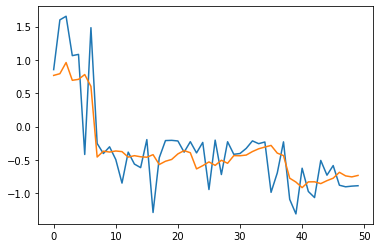

In [24]:
plt.plot(Data.test[1][0:50,0])
plt.plot(linear_predicted[0:50])
plt.show()

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

mse = mean_squared_error(Data.test[1][:,0], linear_predicted.flatten())
rmse = sqrt(mean_squared_error(Data.test[1][:,0], linear_predicted.flatten()))
mae = mean_absolute_error(Data.test[1][:,0], linear_predicted.flatten())
rse_val = rse(Data.test[1][:,0], linear_predicted.flatten())

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'RSE: {rse_val}')

accuracy_stats['rmse']['mlp'] = rmse
accuracy_stats['rse']['mlp'] = rse_val
# accuracy_stats['corr']['mlp'] = corr
# accuracy_stats['accuracy']['mlp'] = acc
accuracy_stats['mae']['mlp'] = mae
accuracy_stats['predicted']['mlp'] = linear_predicted
accuracy_stats['mse']['mlp'] = mse

MSE: 0.16454476118087769
RMSE: 0.40564117293598007
MAE: 0.2996369004249573
RSE: 0.36447232961654663


## SIMPLE LSTM

Here we run our data through a simple lstm for comparison

In [26]:
Data.train[0][:,:,0][0]

array([ 0.4384361 ,  0.14805679,  0.04056996,  0.19512911, -0.15146716,
        0.21926492, -0.08700505,  0.16394745,  0.13351533,  0.26363885],
      dtype=float32)

In [27]:
Data.train[0][:,:,0][0]

array([ 0.4384361 ,  0.14805679,  0.04056996,  0.19512911, -0.15146716,
        0.21926492, -0.08700505,  0.16394745,  0.13351533,  0.26363885],
      dtype=float32)

In [108]:
# define lstm network

# lstm_model = tf.keras.models.Sequential([
#     # Shape [batch, time, features] => [batch, time, lstm_units]
#     tf.keras.layers.GRU(32, input_shape=(10), return_sequences=False),
#     # Shape => [batch, time, features]
#     tf.keras.layers.Dense(units=1)
# ])

ts_inputs = tf.keras.Input(shape=(10,1))
x = tf.keras.layers.LSTM(units=250, dropout=0.2, recurrent_dropout=0.1)(ts_inputs)
# x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1,activation='linear')(x)
lstm_model = tf.keras.Model(inputs=ts_inputs, outputs=outputs)

In [109]:
lstm_model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf_rse, tf_corr, tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError(), tf.metrics.RootMeanSquaredError()])

In [110]:
lstm_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 10, 1)]           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 250)               252000    
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 251       
Total params: 252,251
Trainable params: 252,251
Non-trainable params: 0
_________________________________________________________________


In [111]:
history = lstm_model.fit(Data.train[0][:,:,0], Data.train[1][:,0], 
               epochs=100, 
               validation_data=(Data.valid[0][:,:,0], Data.valid[1][:,0]), 
               callbacks=[early_stopping],
               shuffle=False)

Epoch 1/100
363/363 [==============================] - 16s 43ms/step - loss: 0.1797 - tf_rse: 4.7552 - tf_corr: 0.2534 - mean_absolute_error: 0.3050 - mean_squared_error: 0.1797 - root_mean_squared_error: 0.4239 - val_loss: 0.1606 - val_tf_rse: 0.8312 - val_tf_corr: 0.6184 - val_mean_absolute_error: 0.3037 - val_mean_squared_error: 0.1606 - val_root_mean_squared_error: 0.4007
Epoch 2/100
363/363 [==============================] - 15s 41ms/step - loss: 0.1681 - tf_rse: 4.4545 - tf_corr: 0.2514 - mean_absolute_error: 0.2919 - mean_squared_error: 0.1681 - root_mean_squared_error: 0.4100 - val_loss: 0.1639 - val_tf_rse: 0.8418 - val_tf_corr: 0.6198 - val_mean_absolute_error: 0.3074 - val_mean_squared_error: 0.1639 - val_root_mean_squared_error: 0.4049
Epoch 3/100
363/363 [==============================] - 15s 41ms/step - loss: 0.1659 - tf_rse: 4.2435 - tf_corr: 0.2570 - mean_absolute_error: 0.2891 - mean_squared_error: 0.1659 - root_mean_squared_error: 0.4073 - val_loss: 0.1608 - val_tf_rs

In [112]:
lstm_stats = lstm_model.evaluate(Data.test[0][:,:,0], Data.test[1][:,0])
lstm_stats

92/92 [==============================] - 1s 8ms/step - loss: 0.1639 - tf_rse: 0.8024 - tf_corr: 0.4944 - mean_absolute_error: 0.2983 - mean_squared_error: 0.1639 - root_mean_squared_error: 0.4049


[0.1639350950717926,
 0.8023953437805176,
 0.494402676820755,
 0.298321932554245,
 0.1639350950717926,
 0.40488898754119873]

In [113]:
lstm_predicted = lstm_model.predict(Data.test[0][:,:,0]).flatten()

np.save('predicted_results/lstm_univariate_predicted.npy', lstm_predicted)
np.savetxt('predicted_results/lstm_univariate_predicted.txt', lstm_predicted)
lstm_model.save_weights('./checkpoints/lstm_univariate_weights')

In [114]:
lstm_predicted = np.load('predicted_results/lstm_univariate_predicted.npy')*Data.normalize_std[0] + Data.normalize_mean[0]
data_true = Data.test[1][:,0]*Data.normalize_std[0] + Data.normalize_mean[0]
def mean_absolute_percentage_error(y_true, y_pred): 
  return np.mean(np.abs(y_true - y_pred) / np.abs(y_true)) * 100
lstm_mape = mean_absolute_percentage_error(data_true, lstm_predicted)
lstm_mape

57.89174437522888

In [107]:
data_true.shape

(2933,)

In [105]:
lstm_predicted.shape

(2933,)

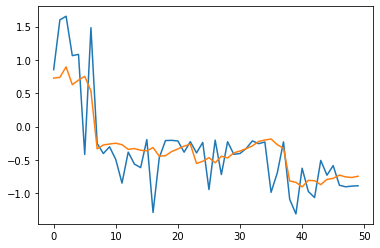

In [34]:
plt.plot(Data.test[1][0:50,0])
plt.plot(lstm_predicted[0:50])
plt.show()

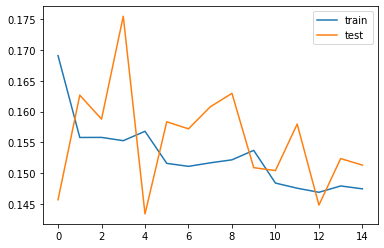

In [35]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

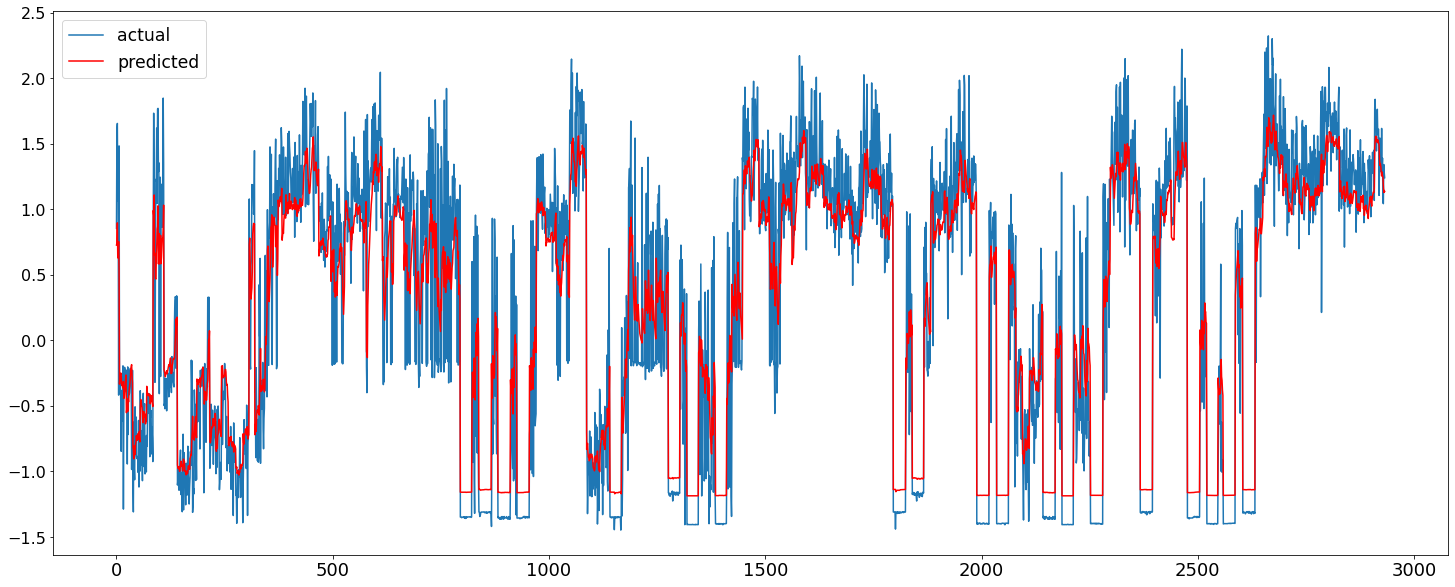

In [36]:
plt.figure(figsize=(25, 10))
plt.plot(Data.test[1][:,0],label="actual")
plt.plot(lstm_predicted, color='r',label="predicted")
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

mse = mean_squared_error(Data.test[1][:,0], lstm_predicted)
rmse = sqrt(mean_squared_error(Data.test[1][:,0], lstm_predicted))
mae = mean_absolute_error(Data.test[1][:,0], lstm_predicted)
rse_val = rse(Data.test[1][:,0], lstm_predicted)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'RSE: {rse_val}')

accuracy_stats['rmse']['lstm'] = rmse
accuracy_stats['rse']['lstm'] = rse_val
# accuracy_stats['corr']['mlp'] = corr
# accuracy_stats['accuracy']['mlp'] = acc
accuracy_stats['mae']['lstm'] = mae
accuracy_stats['predicted']['lstm'] = lstm_predicted
accuracy_stats['mse']['lstm'] = mse

MSE: 0.17465098202228546
RMSE: 0.41791264879432094
MAE: 0.32365673780441284
RSE: 0.37549838423728943


In [38]:
lstm_predicted.shape

(2933,)

In [39]:
Data.test[1][:,0].shape

(2933,)

## Simple GRU

Do the same thing but with a GRU


In [13]:
ts_inputs = tf.keras.Input(shape=(10,1))
x = tf.keras.layers.GRU(units=100, dropout=0.1, recurrent_dropout=0.1)(ts_inputs)
# x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1,activation='linear')(x)
gru_model = tf.keras.Model(inputs=ts_inputs, outputs=outputs)

In [14]:
gru_model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf_rse, tf_corr, tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError(), tf.metrics.RootMeanSquaredError()])

In [15]:
gru_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 10, 1)]           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 100)               30900     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________


In [ ]:
gru_model.fit(Data.train[0][:,:,0], Data.train[1][:,0], 
               epochs=100, 
               validation_data=(Data.valid[0][:,:,0], Data.valid[1][:,0]), 
               callbacks=[early_stopping],
               shuffle=True)

Epoch 1/100
363/363 [==============================] - 14s 39ms/step - loss: 0.1605 - tf_rse: 0.4068 - tf_corr: 0.9208 - mean_absolute_error: 0.2789 - mean_squared_error: 0.1605 - root_mean_squared_error: 0.4006 - val_loss: 0.1437 - val_tf_rse: 0.7663 - val_tf_corr: 0.6207 - val_mean_absolute_error: 0.2671 - val_mean_squared_error: 0.1437 - val_root_mean_squared_error: 0.3790
Epoch 2/100
363/363 [==============================] - 14s 39ms/step - loss: 0.1484 - tf_rse: 0.3937 - tf_corr: 0.9216 - mean_absolute_error: 0.2667 - mean_squared_error: 0.1484 - root_mean_squared_error: 0.3852 - val_loss: 0.1412 - val_tf_rse: 0.7624 - val_tf_corr: 0.6201 - val_mean_absolute_error: 0.2623 - val_mean_squared_error: 0.1412 - val_root_mean_squared_error: 0.3757
Epoch 3/100
363/363 [==============================] - 16s 44ms/step - loss: 0.1494 - tf_rse: 0.3945 - tf_corr: 0.9208 - mean_absolute_error: 0.2666 - mean_squared_error: 0.1494 - root_mean_squared_error: 0.3865 - val_loss: 0.1435 - val_tf_rs

In [ ]:
gru_model.evaluate(Data.test[0][:,:,0], Data.test[1][:,0])

In [ ]:
gru_predicted = gru_model.predict(Data.test[0][:,:,0]).flatten()

np.save('predicted_results/gru_univariate_predicted.npy', gru_predicted)
np.savetxt('predicted_results/gru_univariate_predicted.txt', gru_predicted)
gru_model.save_weights('./checkpoints/gru_univariate_weights')

In [ ]:
gru_predicted = np.load('predicted_results/gru_univariate_predicted.npy')*Data.normalize_std[0] + Data.normalize_mean[0]
data_true = Data.test[1][:,0]*Data.normalize_std[0] + Data.normalize_mean[0]
def mean_absolute_percentage_error(y_true, y_pred): 
  return np.mean(np.abs(y_true - y_pred) / np.abs(y_true)) * 100
gru_mape = mean_absolute_percentage_error(data_true, gru_predicted)
gru_mape

In [ ]:
plt.plot(Data.test[1][0:100,0], label='actual')
plt.plot(gru_predicted[0:100], label="predicted")
plt.legend(loc='best')
plt.show()

In [48]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

mse = mean_squared_error(Data.test[1][:,0], gru_predicted)
rmse = sqrt(mean_squared_error(Data.test[1][:,0], gru_predicted))
mae = mean_absolute_error(Data.test[1][:,0], gru_predicted)
rse_val = rse(Data.test[1][:,0], gru_predicted)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'RSE: {rse_val}')

accuracy_stats['rmse']['gru'] = rmse
accuracy_stats['rse']['gru'] = rse_val
# accuracy_stats['corr']['mlp'] = corr
# accuracy_stats['accuracy']['mlp'] = acc
accuracy_stats['mae']['gru'] = mae
accuracy_stats['predicted']['gru'] = gru_predicted
accuracy_stats['mse']['gru'] = mse

MSE: 0.16447576880455017
RMSE: 0.40555612287888115
MAE: 0.29326778650283813
RSE: 0.3643959164619446


### CNN MODEL

In [111]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Reshape


# cnn_model = Sequential()
# cnn_model.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(10, 3)))
# cnn_model.add(MaxPooling1D(pool_size=2))
# cnn_model.add(Flatten())
# cnn_model.add(Dense(50, activation='relu'))
# cnn_model.add(Dense(1))
# cnn_model.compile(optimizer='adam', loss='mse')

cnn_model = Sequential()
# cnn_model.add(Reshape((10, 1, 1), input_shape=(10, 1)))
cnn_model.add(tf.keras.layers.Lambda(lambda x: x[:, -1:, :], input_shape=(10, 1)))
cnn_model.add(Conv1D(filters=30, kernel_size=1, activation='relu', padding='SAME', strides=1))
# cnn_model.add(MaxPooling1D(pool_size=2, strides=2))
# cnn_model.add(Conv1D(filters=45, kernel_size=5, activation='relu', padding='SAME', strides=1))
# cnn_model.add(MaxPooling1D(pool_size=2, strides=2))
# cnn_model.add(Conv1D(filters=60, kernel_size=5, activation='relu', padding='SAME', strides=1))
# cnn_model.add(MaxPooling1D(pool_size=2, strides=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(120, activation='relu'))
cnn_model.add(Dense(1))
# cnn_model.compile(optimizer='adam', loss='mse')


In [112]:
cnn_model.compile(loss=tf.losses.MeanSquaredError(),
              optimizer=tf.optimizers.Adam(),
              metrics=[tf_rse, tf_corr, tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError(), tf.metrics.RootMeanSquaredError()])

In [113]:
cnn_model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_4 (Lambda)            (None, 1, 1)              0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 1, 30)             60        
_________________________________________________________________
flatten_14 (Flatten)         (None, 30)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 120)               3720      
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 121       
Total params: 3,901
Trainable params: 3,901
Non-trainable params: 0
_________________________________________________________________


In [114]:
cnn_model.fit(Data.train[0][:,:,0], Data.train[1][:,0], 
               epochs=100, 
               validation_data=(Data.valid[0][:,:,0], Data.valid[1][:,0]), 
               callbacks=[early_stopping],
               shuffle=True)

Epoch 1/100
363/363 [==============================] - 1s 4ms/step - loss: 0.2200 - tf_rse: 0.4734 - tf_corr: 0.8894 - mean_absolute_error: 0.3090 - mean_squared_error: 0.2200 - root_mean_squared_error: 0.4690 - val_loss: 0.1916 - val_tf_rse: 0.8975 - val_tf_corr: 0.5869 - val_mean_absolute_error: 0.2941 - val_mean_squared_error: 0.1916 - val_root_mean_squared_error: 0.4377
Epoch 2/100
363/363 [==============================] - 1s 4ms/step - loss: 0.2011 - tf_rse: 0.4593 - tf_corr: 0.8911 - mean_absolute_error: 0.2929 - mean_squared_error: 0.2011 - root_mean_squared_error: 0.4485 - val_loss: 0.1963 - val_tf_rse: 0.9123 - val_tf_corr: 0.5858 - val_mean_absolute_error: 0.3135 - val_mean_squared_error: 0.1963 - val_root_mean_squared_error: 0.4431
Epoch 3/100
363/363 [==============================] - 1s 4ms/step - loss: 0.1999 - tf_rse: 0.4577 - tf_corr: 0.8907 - mean_absolute_error: 0.2937 - mean_squared_error: 0.1999 - root_mean_squared_error: 0.4471 - val_loss: 0.1914 - val_tf_rse: 0.8

In [115]:
cnn_stats = cnn_model.evaluate(Data.test[0][:,:,0], Data.test[1][:,0])
cnn_stats

92/92 [==============================] - 0s 3ms/step - loss: 0.2544 - tf_rse: 1.0101 - tf_corr: 0.4386 - mean_absolute_error: 0.3348 - mean_squared_error: 0.2544 - root_mean_squared_error: 0.5044


[0.25444233417510986,
 1.0101447105407715,
 0.43856462836265564,
 0.33478695154190063,
 0.25444233417510986,
 0.5044227838516235]

In [117]:
cnn_predicted = cnn_model.predict(Data.test[0][:,:,0]).flatten()

np.save('predicted_results/cnn_univariate_predicted.npy', cnn_predicted)
np.savetxt('predicted_results/cnn_univariate_predicted.txt', cnn_predicted)
cnn_model.save_weights('./checkpoints/cnn_univariate_weights')

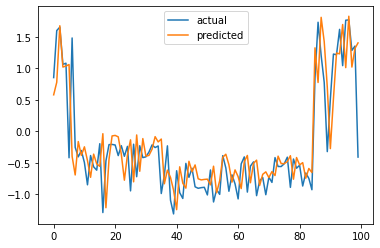

In [118]:
plt.plot(Data.test[1][0:100,0], label='actual')
plt.plot(cnn_predicted[0:100], label="predicted")
plt.legend(loc='best')
plt.show()

In [119]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

mse = mean_squared_error(Data.test[1][:,0], cnn_predicted)
rmse = sqrt(mean_squared_error(Data.test[1][:,0], cnn_predicted))
mae = mean_absolute_error(Data.test[1][:,0], cnn_predicted)
rse_val = rse(Data.test[1][:,0], cnn_predicted)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'RSE: {rse_val}')

accuracy_stats['rmse']['cnn'] = rmse
accuracy_stats['rse']['cnn'] = rse_val
# accuracy_stats['corr']['mlp'] = corr
# accuracy_stats['accuracy']['mlp'] = acc
accuracy_stats['mae']['cnn'] = mae
accuracy_stats['predicted']['cnn'] = cnn_predicted
accuracy_stats['mse']['cnn'] = mse

MSE: 0.25444236397743225
RMSE: 0.5044228027928874
MAE: 0.33478695154190063
RSE: 0.45322853326797485


### CNN-LSTM HYBRID MODEL

In [120]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, Conv2D, LSTM, MaxPooling1D

In [121]:
cnn_lstm_model = Sequential()
cnn_lstm_model.add(Conv1D(filters=64, kernel_size=5, activation='relu', padding='SAME', strides=1, input_shape=(10, 1)))
cnn_lstm_model.add(MaxPooling1D(pool_size=2, strides=2))
cnn_lstm_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='SAME', strides=1))
cnn_lstm_model.add(MaxPooling1D(pool_size=2, strides=2))
# cnn_lstm_model.add(Conv1D(filters=10, kernel_size=3, activation='relu', padding='SAME', strides=1))
# cnn_lstm_model.add(MaxPooling1D(pool_size=2, strides=2))
# cnn_model.add(Flatten())
cnn_lstm_model.add(LSTM(32, dropout=0.1, recurrent_dropout=0.1, return_sequences=False))
cnn_lstm_model.add(Dense(100, activation='relu'))
cnn_lstm_model.add(Dense(1))

In [122]:
cnn_lstm_model.compile(loss=tf.losses.MeanSquaredError(),
                       optimizer=tf.optimizers.Adam(),
                       metrics=[tf_rse, tf_corr, tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError(), tf.metrics.RootMeanSquaredError()])

In [123]:
cnn_lstm_model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_44 (Conv1D)           (None, 10, 64)            384       
_________________________________________________________________
max_pooling1d_38 (MaxPooling (None, 5, 64)             0         
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 5, 64)             12352     
_________________________________________________________________
max_pooling1d_39 (MaxPooling (None, 2, 64)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_33 (Dense)             (None, 100)               3300      
_________________________________________________________________
dense_34 (Dense)             (None, 1)               

In [124]:
cnn_lstm_model.fit(Data.train[0][:,:,0], Data.train[1][:,0], 
                   epochs=100, 
                   validation_data=(Data.valid[0][:,:,0], Data.valid[1][:,0]), 
                   callbacks=[early_stopping],
                   shuffle=True)

Epoch 1/100


ValueError: in user code:

    /home/derek/projects/ml/tf_src_env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:571 train_function  *
        outputs = self.distribute_strategy.run(
    /home/derek/projects/ml/tf_src_env/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/derek/projects/ml/tf_src_env/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/derek/projects/ml/tf_src_env/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/derek/projects/ml/tf_src_env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:531 train_step  **
        y_pred = self(x, training=True)
    /home/derek/projects/ml/tf_src_env/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:885 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    /home/derek/projects/ml/tf_src_env/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:176 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_20 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: [None, 10]


In [350]:
cnn_lstm1_stats = cnn_lstm_model.evaluate(Data.test[0][:,:,0], Data.test[1][:,0])
cnn_lstm1_stats

92/92 [==============================] - 0s 1ms/step - loss: 0.1647 - tf_rse: 0.7924 - tf_corr: 0.5025 - mean_absolute_error: 0.2831 - mean_squared_error: 0.1647 - root_mean_squared_error: 0.4058


[0.16465575993061066,
 0.7924256324768066,
 0.5025315284729004,
 0.28312426805496216,
 0.16465575993061066,
 0.4057779610157013]

In [351]:
cnn_lstm_predicted = cnn_lstm_model.predict(Data.test[0][:,:,0]).flatten()

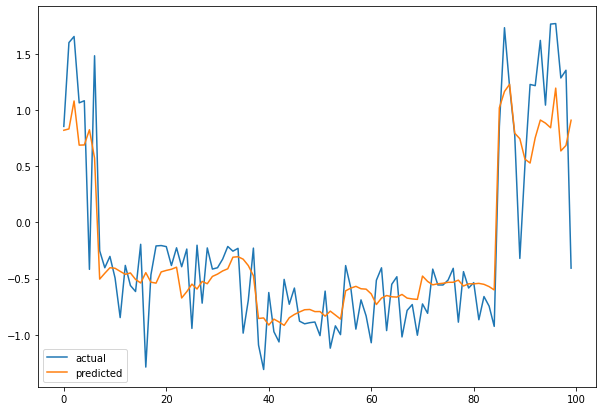

In [352]:
plt.plot(Data.test[1][0:100,0], label='actual')
plt.plot(cnn_lstm_predicted[0:100], label="predicted")
plt.legend(loc='best')
plt.show()

In [353]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

mse = mean_squared_error(Data.test[1][:,0], cnn_lstm_predicted)
rmse = sqrt(mean_squared_error(Data.test[1][:,0], cnn_lstm_predicted))
mae = mean_absolute_error(Data.test[1][:,0], cnn_lstm_predicted)
rse_val = rse(Data.test[1][:,0], cnn_lstm_predicted)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'RSE: {rse_val}')

accuracy_stats['rmse']['cnn_lstm'] = rmse
accuracy_stats['rse']['cnn_lstm'] = rse_val
# accuracy_stats['corr']['mlp'] = corr
# accuracy_stats['accuracy']['mlp'] = acc
accuracy_stats['mae']['cnn_lstm'] = mae
accuracy_stats['predicted']['cnn_lstm'] = cnn_lstm_predicted
accuracy_stats['mse']['cnn_lstm'] = mse

MSE: 0.16465575993061066
RMSE: 0.4057779687595307
MAE: 0.2831242084503174
RSE: 0.3645952343940735


### Take 2

In [166]:
Data.train[0].shape

(11587, 10, 3)

In [86]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                patience=10,
                                                mode='min')

In [87]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, LSTM, MaxPooling2D, Reshape, TimeDistributed, Input, Dropout, GRU

In [125]:
X = Input(shape = (10,1))


#CNN
C = Reshape((10, 1, 1))(X)

# Apply a Conv2D that will transform it into data of dimensions (batchsize, time, 1, NumofFilters)
C = Conv2D(filters=200, kernel_size=(1, 1), kernel_initializer='glorot_uniform')(C)
C = Dropout(0.2)(C)

# Adjust data dimensions by removing axis=2 which is always equal to 1
c_shape = K.int_shape(C)
C = Reshape((c_shape[1], c_shape[3]))(C)

# Apply a GRU layer (with activation set to 'relu' as per the paper) and take the returned states as result
_, R = GRU(200, activation="relu", return_sequences = False, return_state = True)(C)
R    = Dropout(0.2)(R)
Y = Flatten()(R)
Y = Dense(1)(Y)
cnn_lstm_model2 = Model(inputs = X, outputs = Y)

In [126]:
cnn_lstm_model2.compile(loss=tf.losses.MeanSquaredError(),
                       optimizer=tf.optimizers.Adam(),
                       metrics=[tf_rse, tf_corr, tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError(), tf.metrics.RootMeanSquaredError()])

In [127]:
cnn_lstm_model2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 10, 1)]           0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 10, 1, 1)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 1, 200)        400       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 1, 200)        0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 10, 200)           0         
_________________________________________________________________
gru_1 (GRU)                  [(None, 200), (None, 200) 241200    
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0   

In [128]:
# tf.random.set_seed(123456)
cnn_lstm_model2.fit(Data.train[0][:,:,0], Data.train[1][:,0], 
                   epochs=10, 
                   validation_data=(Data.valid[0][:,:,0], Data.valid[1]), 
                   callbacks=[early_stopping],
                   shuffle=True)

Epoch 1/10
363/363 [==============================] - 10s 27ms/step - loss: 0.1505 - tf_rse: 0.3953 - tf_corr: 0.9242 - mean_absolute_error: 0.2632 - mean_squared_error: 0.1505 - root_mean_squared_error: 0.3880 - val_loss: 1.6662 - val_tf_rse: 1.4450 - val_tf_corr: nan - val_mean_absolute_error: 0.9964 - val_mean_squared_error: 1.6662 - val_root_mean_squared_error: 1.2908
Epoch 2/10
363/363 [==============================] - 9s 26ms/step - loss: 0.1423 - tf_rse: 0.3941 - tf_corr: 0.9257 - mean_absolute_error: 0.2561 - mean_squared_error: 0.1423 - root_mean_squared_error: 0.3773 - val_loss: 1.6375 - val_tf_rse: 1.4170 - val_tf_corr: nan - val_mean_absolute_error: 0.9808 - val_mean_squared_error: 1.6375 - val_root_mean_squared_error: 1.2797
Epoch 3/10
363/363 [==============================] - 9s 26ms/step - loss: 0.1406 - tf_rse: 0.3973 - tf_corr: 0.9277 - mean_absolute_error: 0.2558 - mean_squared_error: 0.1406 - root_mean_squared_error: 0.3750 - val_loss: 1.7216 - val_tf_rse: 1.4632 -

In [132]:
cnn_lstm_model2.evaluate(Data.test[0][:,:,0], Data.test[1])

92/92 [==============================] - 0s 5ms/step - loss: 1.9035 - tf_rse: 1.4334 - tf_corr: nan - mean_absolute_error: 1.1052 - mean_squared_error: 1.9035 - root_mean_squared_error: 1.3797


[1.903482437133789,
 1.4333912134170532,
 nan,
 1.105199933052063,
 1.903482437133789,
 1.3796674013137817]

In [134]:
cnn_lstm_model2_predicted = cnn_lstm_model2.predict(Data.test[0][:,:,0])

np.save('predicted_results/cnn_lstm_univariate_predicted.npy', cnn_lstm_model2_predicted)
np.savetxt('predicted_results/cnn_lstm_univariate_predicted.txt', cnn_lstm_model2_predicted)
cnn_lstm_model.save_weights('./checkpoints/cnn_lstm_univariate_weights')

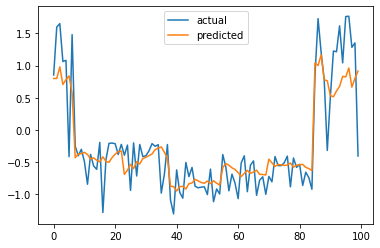

In [135]:
plt.plot(Data.test[1][0:100,0], label='actual')
plt.plot(cnn_lstm_model2_predicted[0:100,0], label="predicted")
plt.legend(loc='best')
plt.show()

In [136]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

mse = mean_squared_error(Data.test[1][:,0], cnn_lstm_model2_predicted.flatten())
rmse = sqrt(mean_squared_error(Data.test[1][:,0], cnn_lstm_model2_predicted.flatten()))
mae = mean_absolute_error(Data.test[1][:,0], cnn_lstm_model2_predicted.flatten())
rse_val = rse(Data.test[1][:,0], cnn_lstm_model2_predicted[:,0].flatten())

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'RSE: {rse_val}')

accuracy_stats['rmse']['cnn_lstm2'] = rmse
accuracy_stats['rse']['cnn_lstm2'] = rse_val
# accuracy_stats['corr']['mlp'] = corr
# accuracy_stats['accuracy']['mlp'] = acc
accuracy_stats['mae']['cnn_lstm2'] = mae
accuracy_stats['predicted']['cnn_lstm2'] = cnn_lstm_model2_predicted
accuracy_stats['mse']['cnn_lstm2'] = mse

MSE: 0.16193687915802002
RMSE: 0.40241381581404484
MAE: 0.286216139793396
RSE: 0.3615725338459015


### LSTNET MODEL

In [9]:
from tensorflow.keras.models import Model, model_from_json

custom_objects = {
        'PreSkipTrans': PreSkipTrans,
        'PostSkipTrans': PostSkipTrans,
        'PreARTrans': PreARTrans,
        'PostARTrans': PostARTrans
        }


def custom_loss(y_true, y_pred):
    # print("CUSTOM LOSS BABBBY")
    # print(type(y_true))
    # print(type(y_pred))
    # print(y_true)
    # print(y_true.shape)
    # tf.print(y_true[:,0, sys.stdout)
    return tf.keras.losses.mean_absolute_error(y_true[:,0], y_pred[:,0])

file = 'models/model_univar_1.json'
lstnet_model = None
with open(file, "r") as json_file:
  lstnet_model = model_from_json(json_file.read(), custom_objects=custom_objects)


In [10]:
lstnet_model.compile(loss=custom_loss,
                       optimizer=tf.optimizers.Adam(),
                       metrics=[single_rse, single_corr, tf_rse, tf_corr, tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError(), tf.metrics.RootMeanSquaredError()])

In [11]:
lstnet_model.fit(Data.train[0][:,:,0], Data.train[1][:,0], 
                   epochs=20, 
                   validation_data=(Data.valid[0][:,:,0], Data.valid[1][:,0]), 
                   callbacks=[early_stopping],
                   shuffle=True,
                   batch_size=91)

Epoch 1/20
128/128 [==============================] - 4s 29ms/step - loss: 0.5047 - single_rse: 0.6999 - single_corr: 0.7247 - tf_rse: 0.6999 - tf_corr: 0.7247 - mean_absolute_error: 0.5047 - mean_squared_error: 0.7274 - root_mean_squared_error: 0.8529 - val_loss: 0.3296 - val_single_rse: 0.7129 - val_single_corr: 0.7073 - val_tf_rse: 0.7129 - val_tf_corr: 0.7073 - val_mean_absolute_error: 0.3296 - val_mean_squared_error: 0.2270 - val_root_mean_squared_error: 0.4765
Epoch 2/20
128/128 [==============================] - 3s 26ms/step - loss: 0.3539 - single_rse: 0.5160 - single_corr: 0.8681 - tf_rse: 0.5160 - tf_corr: 0.8681 - mean_absolute_error: 0.3539 - mean_squared_error: 0.2570 - root_mean_squared_error: 0.5070 - val_loss: 0.3142 - val_single_rse: 0.6850 - val_single_corr: 0.7294 - val_tf_rse: 0.6850 - val_tf_corr: 0.7294 - val_mean_absolute_error: 0.3142 - val_mean_squared_error: 0.2106 - val_root_mean_squared_error: 0.4589
Epoch 3/20
128/128 [==============================] - 3s 2

In [12]:
lstnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10, 1)]      0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 10, 1, 1)     0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 10, 1, 200)   400         reshape[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 10, 1, 200)   0           conv2d[0][0]                     
______________________________________________________________________________________________

In [13]:
lstnet_model.evaluate(Data.test[0][:,:,0], Data.test[1])

92/92 [==============================] - 1s 6ms/step - loss: 0.2820 - single_rse: 0.8036 - single_corr: 0.4887 - tf_rse: 0.8036 - tf_corr: 0.4887 - mean_absolute_error: 0.2820 - mean_squared_error: 0.1698 - root_mean_squared_error: 0.4121


[0.28204694390296936,
 0.8036040663719177,
 0.4887180030345917,
 0.8036040663719177,
 0.4887180030345917,
 0.28204694390296936,
 0.16981381177902222,
 0.4120847284793854]

In [14]:
lstnet_predicted = lstnet_model.predict(Data.test[0][:,:,0])

np.save('predicted_results/lstnet_univariate_predicted.npy', lstnet_predicted)
np.savetxt('predicted_results/lstnet_univariate_predicted.txt', lstnet_predicted)
lstnet_model.save_weights('./checkpoints/lstnet_univariate_weights')

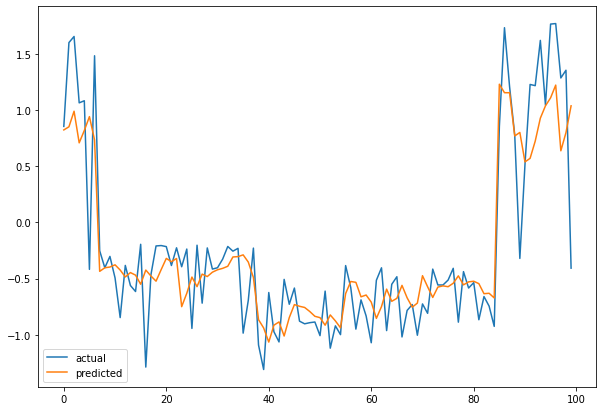

In [363]:
plt.plot(Data.test[1][0:100,0], label='actual')
plt.plot(lstnet_predicted[0:100, 0], label="predicted")
plt.legend(loc='best')
plt.show()

In [364]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
print(f'MSE: {mean_squared_error(Data.test[1][:,0], lstnet_predicted[:,0])}')
print(f'RMSE: {sqrt(mean_squared_error(Data.test[1][:,0], lstnet_predicted[:,0]))}')
print(f'MAE: {mean_absolute_error(Data.test[1][:,0], lstnet_predicted[:,0])}')
print(f'RSE: {rse(Data.test[1][:,0], lstnet_predicted[:,0])}')

MSE: 0.16843312978744507
RMSE: 0.41040605476460146
MAE: 0.272156685590744
RSE: 0.3687536418437958


In [365]:
Data.test[1][:,0]

array([0.85369205, 1.5995036 , 1.6537718 , ..., 1.3404559 , 1.2792919 ,
       1.2401649 ], dtype=float32)

In [366]:
lstnet_predicted[:,0]

array([0.8223007, 0.8502383, 0.9887984, ..., 1.1998756, 1.189584 ,
       1.2423778], dtype=float32)

In [367]:
def mean_absolute_percentage_error(y_true, y_pred): 
  return np.mean(np.abs(y_true - y_pred) / np.abs(y_true)) * 100

In [368]:
mean_absolute_percentage_error(Data.test[1][:,0]*Data.normalize_std[0] + Data.normalize_mean[0], lstnet_predicted[:,0]*Data.normalize_std[0] + Data.normalize_mean[0])

27.10437774658203

# Comparison between Different Methods

In [66]:
mlp_predicted = np.load('predicted_results/mlp_univariate_predicted.npy')*Data.normalize_std[0] + Data.normalize_mean[0]
lstm_predicted = np.load('predicted_results/lstm_univariate_predicted.npy')*Data.normalize_std[0] + Data.normalize_mean[0]
gru_predicted = np.load('predicted_results/gru_univariate_predicted.npy')*Data.normalize_std[0] + Data.normalize_mean[0]
cnn_predicted = np.load('predicted_results/cnn_univariate_predicted.npy')*Data.normalize_std[0] + Data.normalize_mean[0]
cnn_lstm_predicted = np.load('predicted_results/cnn_lstm_univariate_predicted.npy')*Data.normalize_std[0] + Data.normalize_mean[0]
lstnet_predicted = np.load('predicted_results/lstnet_univariate_predicted.npy')*Data.normalize_std[0] + Data.normalize_mean[0]

data_true = Data.test[1][:,0]*Data.normalize_std[0] + Data.normalize_mean[0]

In [67]:
data_true.shape

(2933,)

In [68]:
mlp_predicted = np.load('predicted_results/mlp_univariate_predicted.npy')*Data.normalize_std[0] + Data.normalize_mean[0]
data_true = Data.test[1][:,0]*Data.normalize_std[0] + Data.normalize_mean[0]
def mean_absolute_percentage_error(y_true, y_pred): 
  return np.mean(np.abs(y_true - y_pred) / np.abs(y_true)) * 100
mlp_mape = mean_absolute_percentage_error(data_true, mlp_predicted[:, 0])
mlp_mape

50.65979361534119

In [69]:
from cycler import cycler

# Create cycler object. Use any styling from above you please
monochrome = (cycler('color', ['k']) * cycler('linestyle', ['-', '--', ':']) * cycler('marker', ['^',',', '.']))

# Print examples of output from cycler object. 
# A cycler object, when called, returns a `iter.cycle` object that iterates over items indefinitely

default_cycler = (cycler(color=['black', 'r', 'b', 'y', 'teal', 'green', 'purple']) +
                  cycler(linestyle=['-', '--', ':', '-.', '-.', '-', '--']))

In [70]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

cmap_1 = ListedColormap(["darkorange", "gold", "lawngreen", "lightseagreen"])

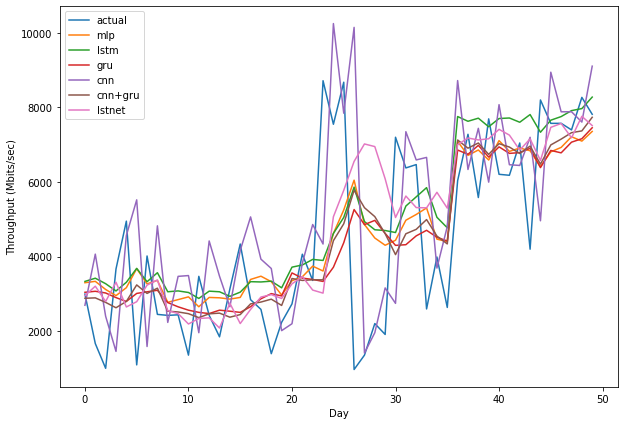

In [71]:
start_time = 150
end_time = 200
plt.rcParams["figure.figsize"] = (10,7)
# plt.rc('axes', prop_cycle=default_cycler)
# plt.style.use('grayscale')
plt.plot(data_true[start_time:end_time], label='actual')
plt.plot(mlp_predicted[start_time:end_time, 0], label="mlp")
plt.plot(lstm_predicted[start_time:end_time], label="lstm")
plt.plot(gru_predicted[start_time:end_time], label="gru")
plt.plot(cnn_predicted[start_time:end_time], label="cnn")
plt.plot(cnn_lstm_predicted[start_time:end_time, 0], label="cnn+gru")
plt.plot(lstnet_predicted[start_time:end_time, 0], label="lstnet")
plt.ylabel('Throughput (Mbits/sec)')
plt.xlabel('Day')
plt.legend(loc='best')
plt.show()

### RMSE

In [72]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [73]:
mlp_rmse = sqrt(mean_squared_error(data_true, mlp_predicted[:, 0]))
mlp_rmse

2728.8762339102154

In [74]:
lstm_rmse = sqrt(mean_squared_error(data_true, lstm_predicted))
lstm_rmse

2787.721919417358

In [75]:
gru_rmse = sqrt(mean_squared_error(data_true, gru_predicted))
gru_rmse

2705.296564149668

In [76]:
cnn_rmse = sqrt(mean_squared_error(data_true, cnn_predicted))
cnn_rmse

3364.7950903435412

In [77]:
cnn_lstm_rmse = sqrt(mean_squared_error(data_true, cnn_lstm_predicted[:, 0]))
cnn_lstm_rmse

2684.335485739441

In [78]:
lstnet_rmse = sqrt(mean_squared_error(data_true, lstnet_predicted[:, 0]))
lstnet_rmse

2748.8464853461714

Text(0, 0.5, 'Root Mean Squared Error (RMSE)')

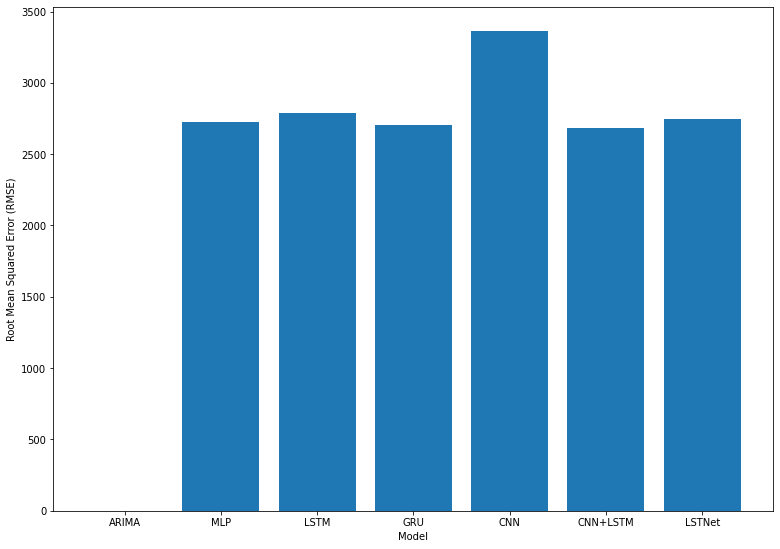

In [79]:
fig = plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.bar(x=['ARIMA', 'MLP', 'LSTM', 'GRU', 'CNN', 'CNN+LSTM', 'LSTNet'], 
        height=[0.45, mlp_rmse, lstm_rmse, gru_rmse, cnn_rmse, cnn_lstm_rmse, lstnet_rmse])
ax.set_xlabel('Model')

ax.set_ylabel('Root Mean Squared Error (RMSE)')

### MAPE

In [80]:
def mean_absolute_percentage_error(y_true, y_pred): 
  return np.mean(np.abs(y_true - y_pred) / np.abs(y_true)) * 100

In [81]:
mlp_mape = mean_absolute_percentage_error(data_true, mlp_predicted[:, 0])
mlp_mape

50.65979361534119

In [82]:
lstm_mape = mean_absolute_percentage_error(data_true, lstm_predicted)
lstm_mape

73.50890040397644

In [83]:
gru_mape = mean_absolute_percentage_error(data_true, gru_predicted)
gru_mape

41.89257621765137

In [84]:
cnn_mape = mean_absolute_percentage_error(data_true, cnn_predicted)
cnn_mape

40.77326059341431

In [85]:
cnn_lstm_mape = mean_absolute_percentage_error(data_true, cnn_lstm_predicted[:, 0])
cnn_lstm_mape

36.92401349544525

In [86]:
lstnet_mape = mean_absolute_percentage_error(data_true, lstnet_predicted[:, 0])
lstnet_mape

39.66439366340637

Text(0, 0.5, 'Mean Absolute Percentage Error (MAPE) %')

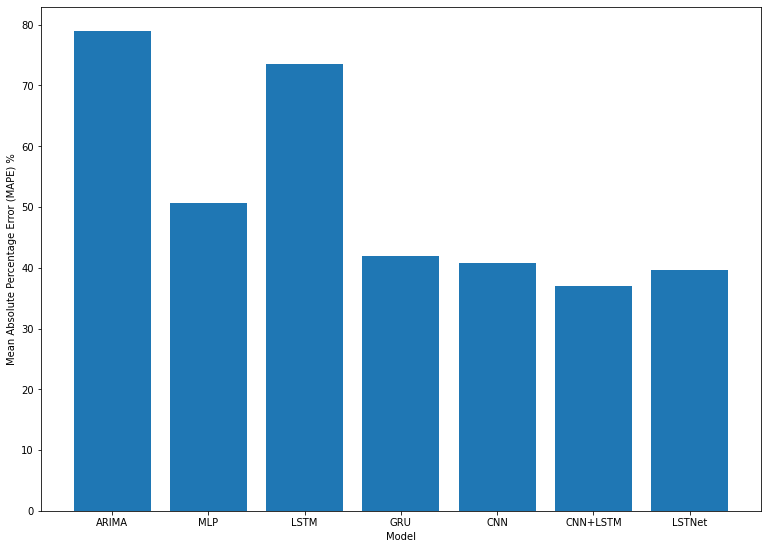

In [87]:
fig = plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.bar(x=['ARIMA', 'MLP', 'LSTM', 'GRU', 'CNN', 'CNN+LSTM', 'LSTNet'], 
        height=[79, mlp_mape, lstm_mape, gru_mape, cnn_mape, cnn_lstm_mape, lstnet_mape])
ax.set_xlabel('Model')
# ax.set_ylim(0.0, 0.9)
ax.set_ylabel('Mean Absolute Percentage Error (MAPE) %')

### CORR

In [88]:
mlp_corr = corr(data_true, mlp_predicted[:, 0])
mlp_corr

0.93350035

In [89]:
lstm_corr = corr(data_true, lstm_predicted)
lstm_corr

0.9330214

In [90]:
gru_corr = corr(data_true, gru_predicted)
gru_corr

0.9340962

In [91]:
cnn_corr = corr(data_true, cnn_predicted)
cnn_corr

0.89548427

In [92]:
cnn_lstm_corr = corr(data_true, cnn_lstm_predicted[:, 0])
cnn_lstm_corr

0.93441063

In [93]:
lstnet_corr = corr(data_true, lstnet_predicted[:, 0])
lstnet_corr

0.9291744

In [94]:
import scipy
scipy.stats.pearsonr(data_true, lstnet_predicted[:, 0])

(0.9291744350269123, 0.0)

0.8640207602826172

Text(0, 0.5, 'Mean Absolute Percentage Error (MAPE) %')

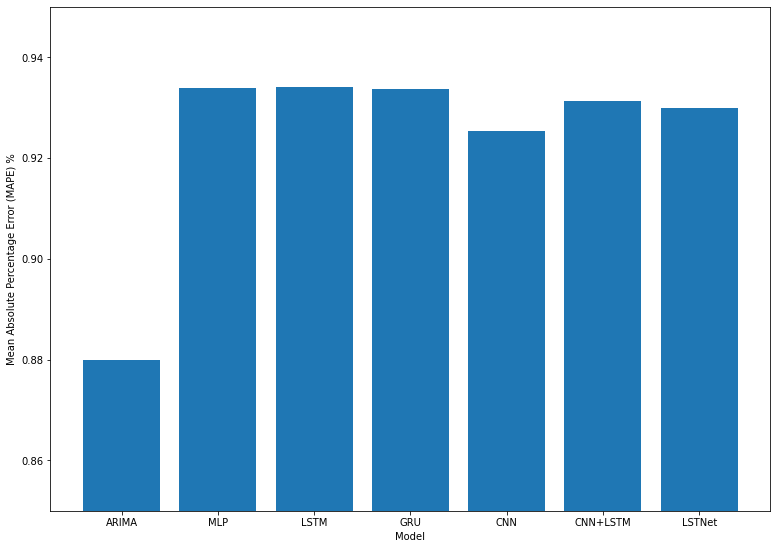

In [427]:
fig = plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.bar(x=['ARIMA', 'MLP', 'LSTM', 'GRU', 'CNN', 'CNN+LSTM', 'LSTNet'], 
        height=[0.88, mlp_corr, lstm_corr, gru_corr, cnn_corr, cnn_lstm_corr, lstnet_corr])
ax.set_xlabel('Model')
ax.set_ylim(0.85, 0.95)
ax.set_ylabel('Mean Absolute Percentage Error (MAPE) %')

### r2

In [ ]:
from sklearn.metrics import r2_score

In [473]:
mlp_r2 = r2_score(data_true, mlp_predicted[:, 0])
lstm_r2 = r2_score(data_true, lstm_predicted)
gru_r2 = r2_score(data_true, gru_predicted)
cnn_r2 = r2_score(data_true, cnn_predicted)
cnn_lstm_r2 = r2_score(data_true, cnn_lstm_predicted[:, 0])
lstnet_r2 = r2_score(data_true, lstnet_predicted[:, 0])


In [475]:
print(f'mlp r2:     {mlp_r2}')
print(f'lstm r2:    {lstm_r2}')
print(f'gru r2:     {gru_r2}')
print(f'cnn r2:     {cnn_r2}')
print(f'cnn+gru r2: {cnn_lstm_r2}')
print(f'lstnet r2:  {lstnet_r2}')


mlp_r2:     0.8691936608867736
lstm_r2:    0.8714567071607718
gru r2:     0.8712802577295661
cnn r2:     0.8526073274512455
cnn_gru r2: 0.8670703015048002
lstnet r2:  0.8640207602826172


### RRSE

In [396]:
mlp_rrse = rse(data_true, mlp_predicted[:, 0])
mlp_rrse

0.3616716

In [397]:
lstm_rrse = rse(data_true, lstm_predicted)
lstm_rrse

0.3585294

In [398]:
gru_rrse = rse(data_true, gru_predicted)
gru_rrse

0.35877535

In [399]:
cnn_rrse = rse(data_true, cnn_predicted)
cnn_rrse

0.38391754

In [400]:
cnn_lstm_rrse = rse(data_true, cnn_lstm_predicted[:, 0].flatten())
cnn_lstm_rrse

0.36459526

In [401]:
lstnet_rrse = rse(data_true, lstnet_predicted[:, 0].flatten())
lstnet_rrse

0.36875364

Text(0, 0.5, 'Root Relative Squared Error (RRSE)')

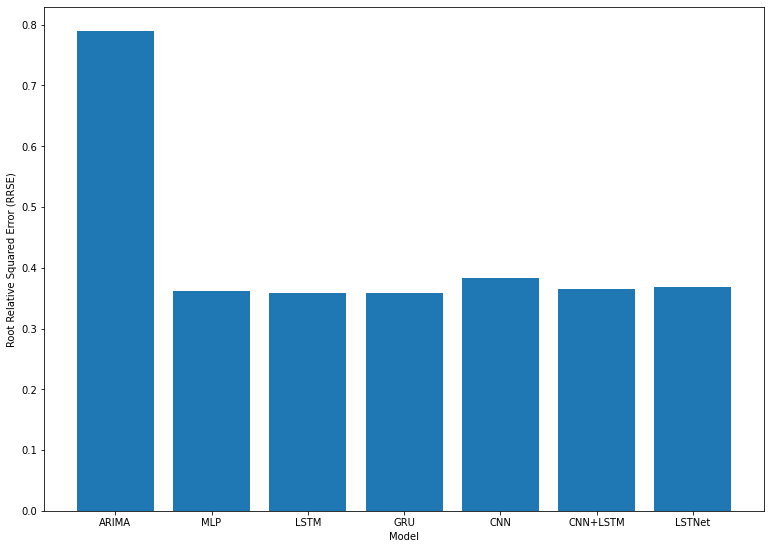

In [402]:
fig = plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.bar(x=['ARIMA', 'MLP', 'LSTM', 'GRU', 'CNN', 'CNN+LSTM', 'LSTNet'], 
        height=[0.79, mlp_rrse,lstm_rrse,gru_rrse,cnn_rrse,cnn_lstm_rrse,lstnet_rrse])
ax.set_xlabel('Model')
# ax.set_ylim(0.0, 0.9)
ax.set_ylabel('Root Relative Squared Error (RRSE)')

### MAE

In [428]:
from sklearn.metrics import mean_absolute_error

In [429]:
mlp_mae = mean_absolute_error(data_true, mlp_predicted[:, 0])
mlp_mae

1885.6161

In [430]:
lstm_mae = mean_absolute_error(data_true, lstm_predicted)
lstm_mae

1847.0719

In [431]:
gru_mae = mean_absolute_error(data_true, gru_predicted)
gru_mae

1899.1553

In [432]:
cnn_mae = mean_absolute_error(data_true, cnn_predicted)
cnn_mae

1960.9369

In [433]:
cnn_lstm_mae = mean_absolute_error(data_true, cnn_lstm_predicted[:, 0])
cnn_lstm_mae

1888.6041

In [434]:
lstnet_mae = mean_absolute_error(data_true, lstnet_predicted[:, 0])
lstnet_mae

1815.4442

Text(0, 0.5, 'Mean Absolute Percentage Error (MAPE) %')

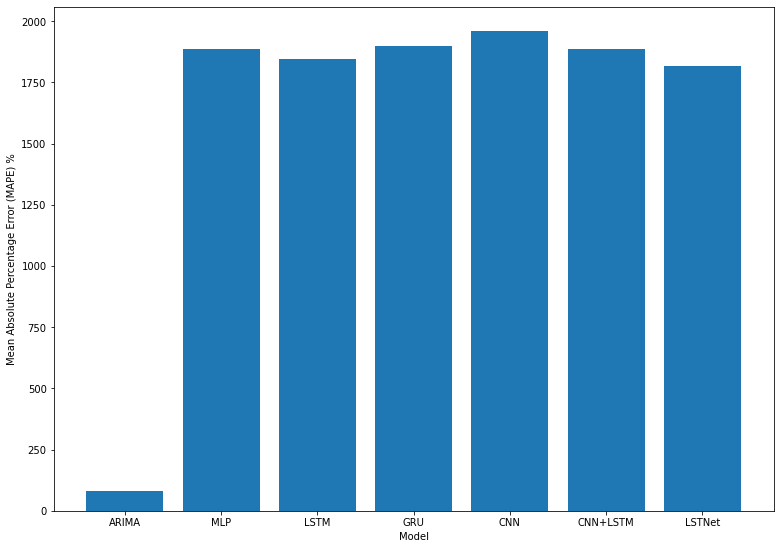

In [435]:
fig = plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.bar(x=['ARIMA', 'MLP', 'LSTM', 'GRU', 'CNN', 'CNN+LSTM', 'LSTNet'], 
        height=[79, mlp_mae, lstm_mae, gru_mae, cnn_mae, cnn_lstm_mae, lstnet_mae])
ax.set_xlabel('Model')
# ax.set_ylim(0.0, 0.9)
ax.set_ylabel('Mean Absolute Percentage Error (MAPE) %')

### RMSRE (root mean square relative error)

In [ ]:
from sklearn.metrics import mean_absolute_error

In [ ]:
mlp_mae = mean_absolute_error(data_true, mlp_predicted[:, 0])
mlp_mae

In [ ]:
lstm_mae = mean_absolute_error(data_true, lstm_predicted)
lstm_mae

In [ ]:
gru_mae = mean_absolute_error(data_true, gru_predicted)
gru_mae

In [ ]:
cnn_mae = mean_absolute_error(data_true, cnn_predicted)
cnn_mae

In [ ]:
cnn_lstm_mae = mean_absolute_error(data_true, cnn_lstm_predicted[:, 0])
cnn_lstm_mae

In [ ]:
lstnet_mae = mean_absolute_error(data_true, lstnet_predicted[:, 0])
lstnet_mae

In [ ]:
fig = plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.bar(x=['ARIMA', 'MLP', 'LSTM', 'GRU', 'CNN', 'CNN+LSTM', 'LSTNet'], 
        height=[79, mlp_mae, lstm_mae, gru_mae, cnn_mae, cnn_lstm_mae, lstnet_mae])
ax.set_xlabel('Model')
# ax.set_ylim(0.0, 0.9)
ax.set_ylabel('Mean Absolute Percentage Error (MAPE) %')

### CDF of Relative Error

In [455]:
mlp_relative_error = (data_true - mlp_predicted[:, 0]) / data_true
lstm_relative_error = (data_true - lstm_predicted) / data_true

In [461]:
mlp_residual_error = (data_true - mlp_predicted[:, 0])

In [456]:
mlp_relative_error

array([0.04450344, 0.26728305, 0.21129869, ..., 0.06150539, 0.03058356,
       0.01705436], dtype=float32)

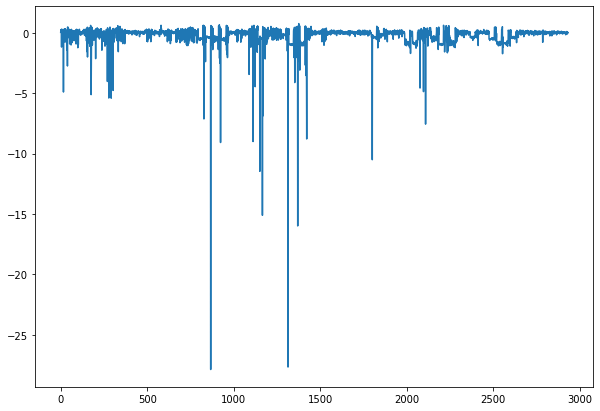

In [457]:
plt.plot(mlp_relative_error)

<ipython-input-465-1e8a19cb1e33>:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  counts, bin_edges = np.histogram (abs(mlp_relative_error), bins=num_bins, normed=True)
<ipython-input-465-1e8a19cb1e33>:5: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  counts, bin_edges = np.histogram (abs(lstm_relative_error), bins=num_bins, normed=True)


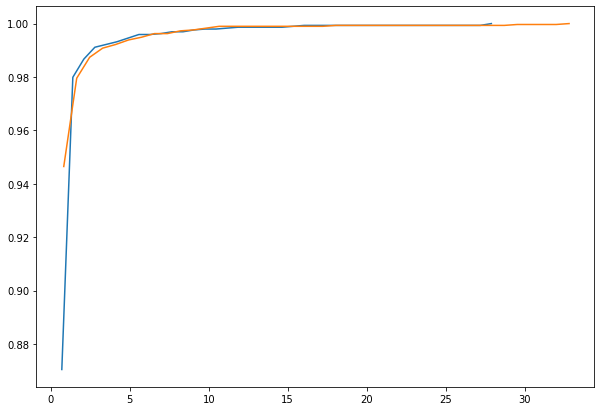

In [465]:
num_bins = 40
counts, bin_edges = np.histogram (abs(mlp_relative_error), bins=num_bins, normed=True)
cdf = np.cumsum (counts)
plt.plot (bin_edges[1:], cdf/cdf[-1])
counts, bin_edges = np.histogram (abs(lstm_relative_error), bins=num_bins, normed=True)
cdf = np.cumsum (counts)
plt.plot (bin_edges[1:], cdf/cdf[-1])

## ARIMA

In [9]:
arima_actual = np.load('predicted_results/arima_data_actual_1.npy')
arima_predicted = np.load('predicted_results/arima_data_predictions_1.npy')

In [10]:
arima_actual[0:300]

array([ 2871. ,  4543. ,    49.6,  7139. ,  6460. ,  4798. ,  4798. ,
        4798. ,  4102. ,  4102. ,  5806. ,  5806. ,  2383. ,  2383. ,
        2383. ,  4122. ,  7760. ,    26.9,  4746. ,  6313. ,  6178. ,
        4893. ,  5196. ,  5196. ,  5196. ,  3595. ,  3373. ,  1017. ,
        1017. ,  6668. ,  7706. ,  7706. ,  2688. ,  2688. ,  2688. ,
        6459. ,  6459. ,  5796. ,  6619. ,  6640. ,  6221. ,  5773. ,
        3790. ,  4025. ,  8221. ,  8319. ,  8295. ,  8300. ,  6577. ,
        6577. ,  6052. ,  6229. ,  6229. ,  6229. ,  6272. ,  3954. ,
        8280. ,  4474. ,  5550. ,  5550. ,  5550. ,  5550. ,  6532. ,
        6532. ,  3968. ,  2672. ,  5462. ,  2871. ,  4074. ,  4074. ,
        5127. ,  5127. ,   496. ,  4008. ,  2247. ,  1812. ,  2236. ,
        2248. ,  4015. ,  4015. ,   360. ,  2396. ,  2016. ,  3379. ,
        2030. ,  2604. ,  3394. ,  3295. ,  3295. ,  4703. ,  4508. ,
         960. ,  3587. ,  2403. ,  2774. ,  4461. ,  4461. ,  3900. ,
        3900. ,  802

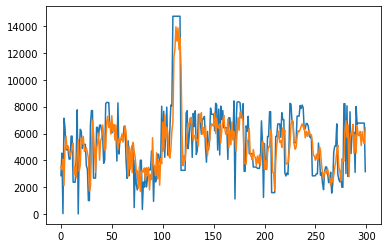

In [11]:
plt.plot(arima_actual[0:300])
plt.plot(arima_predicted[0:300])

In [12]:
arima_rrse = rse(arima_actual, arima_predicted)
arima_rrse

0.4440730315422365

In [13]:
from sklearn.metrics import mean_absolute_error
arima_mae = mean_absolute_error(arima_actual, arima_predicted)
arima_mae

1103.2639156359296

In [14]:
def mean_absolute_percentage_error(y_true, y_pred): 
  return np.mean(np.abs(y_true - y_pred) / np.abs(y_true)) * 100

arima_mape = mean_absolute_percentage_error(arima_actual, arima_predicted)
arima_mape

562.3442057046866

In [15]:
from sklearn.metrics import mean_squared_error
from math import sqrt

arima_rmse = sqrt(mean_squared_error(arima_actual, arima_predicted))
arima_rmse

1873.1875281994423

In [16]:
arima_corr = corr(arima_actual, arima_predicted)
arima_corr

0.8965454379461014

# Prediction for all models on a single route (from test dataset)

In [243]:
test_sample = np.load('numpy_group_test_data/1_stream_test_sample_group_95.npy')
test_target = np.load('numpy_group_test_data/1_stream_test_target_group_95.npy')

normalize_mean = 9726.925995055048
normalize_std  = 6670.752950995383


In [244]:
test_target[:,0]

array([1.5046388 , 1.5749458 , 0.83859706, 1.5113847 , 1.3929573 ,
       1.9128387 , 1.2935683 , 1.9832954 , 1.8695152 , 1.295517  ,
       1.5146827 , 1.1646472 , 0.50040436, 1.0991374 , 1.3268478 ,
       1.7437422 , 1.0511668 , 1.3847123 , 2.0201728 , 1.9467179 ,
       1.2463472 , 1.1604499 , 1.0535654 , 1.1547533 , 1.11113   ,
       1.1839854 , 1.378716  , 1.3166541 , 1.1135286 , 2.018074  ,
       1.4009024 , 0.64206755, 1.091642  , 0.6650035 , 1.0532655 ,
       1.3637252 , 1.3889098 , 1.0562637 , 1.1871334 , 1.1874332 ,
       1.4058493 , 1.2040731 , 1.3464857 , 1.2235612 , 1.344387  ,
       1.2602886 , 1.0597116 ], dtype=float32)

In [450]:
import statsmodels.api as sm 

arma_mod = sm.tsa.ARIMA(test_target[:,0], order=(8,0,8))
arma_res = arma_mod.fit(trend='nc', disp=-1)
arma_predictions = arma_res.predict()

/home/derek/projects/ml/tf_src_env/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
/home/derek/projects/ml/tf_src_env/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


In [451]:
arma_predictions

array([0.        , 1.38947745, 1.45990814, 0.87566026, 1.41459005,
       1.19046913, 1.54040455, 1.23708246, 1.87546929, 2.0038211 ,
       1.08621764, 1.80555688, 0.72793828, 0.64024233, 0.38346096,
       1.09554544, 1.5071352 , 1.00848759, 2.19089308, 2.04258843,
       1.60012375, 0.98173788, 1.19172475, 0.8724164 , 0.51954645,
       1.13123414, 1.08916677, 1.50494847, 1.25983053, 1.54846858,
       1.62136415, 1.0123617 , 0.88775489, 0.92009024, 0.53260978,
       0.80013108, 0.86020414, 1.44942403, 1.39414666, 1.33876922,
       1.56902441, 0.9007192 , 0.80709817, 0.8215039 , 1.42197816,
       1.15284328, 1.65363592])

### Load weights for models

In [452]:
# Create a new model instance

# Restore the weights
linear.load_weights('./checkpoints/linear_weights')


In [453]:
linear_test_predict = linear.predict(test_sample)
lstm_test_predict = lstm_model.predict(test_sample)
gru_test_predict = gru_model.predict(test_sample)
cnn_test_predict = cnn_model.predict(test_sample)
cnn_lstm_test_predict = cnn_lstm_model.predict(test_sample)
lstnet_test_predict = lstnet_model.predict(test_sample)

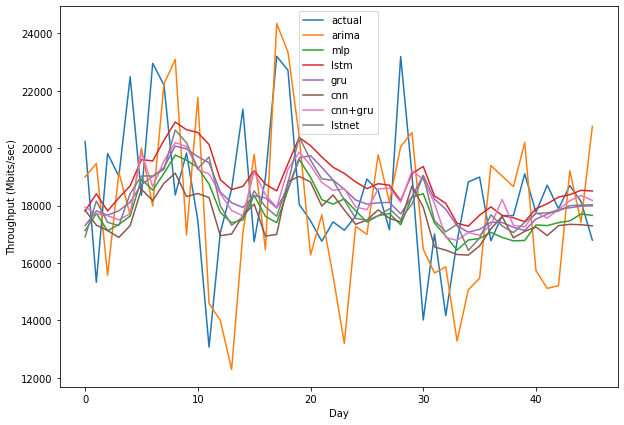

In [454]:
plt.rcParams["figure.figsize"] = (10,7)
plt.plot(test_target[1:,0] * normalize_std + normalize_mean, label='actual')
plt.plot(arma_predictions[1:] * normalize_std + normalize_mean, label='arima')
plt.plot(linear_test_predict[1:] * normalize_std + normalize_mean, label='mlp')
plt.plot(lstm_test_predict[1:] * normalize_std + normalize_mean, label='lstm')
plt.plot(gru_test_predict[1:] * normalize_std + normalize_mean, label='gru')
plt.plot(cnn_test_predict[1:] * normalize_std + normalize_mean, label='cnn')
plt.plot(cnn_lstm_test_predict[1:,0] * normalize_std + normalize_mean, label='cnn+gru')
plt.plot(lstnet_test_predict[1:,0] * normalize_std + normalize_mean, label='lstnet')
plt.ylabel('Throughput (Mbits/sec)')
plt.xlabel('Day')
plt.legend(loc='best')

In [449]:
mean_absolute_percentage_error(test_target[1:,0],)

TypeError: mean_absolute_percentage_error() missing 1 required positional argument: 'y_pred'